In [1]:
import quimb.tensor as qtn
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import itertools
import denseQubits as dq
import exactJWT
import stabilizers as stab
import qubitNetworks as beeky
from itertools import product
import autoray
import scipy.sparse as sparse
import functools
import assorted_conts as ac
import networkx as nx

from quimb.tensor.tensor_core import array_direct_product as adp

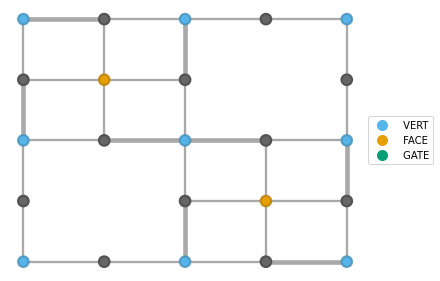

In [136]:
reload(beeky)
nflat = beeky.QubitEncodeNet.random_flat(3,3, bond_dim=5)
nflat.rotate_face_qubit_bonds_(3,3)
nflat.rotate_face_qubit_bonds_(1,1)
nflat.fill_cols_with_identities_()
nflat.fill_rows_with_identities_()



nflat.graph(show_tags=False)
# row_envs = nflat.compute_row_environments(dense=False)
# col_envs = nflat.compute_col_environments(dense=False)
# nflat.graph()

In [143]:
row_envs = nflat.compute_row_environments()

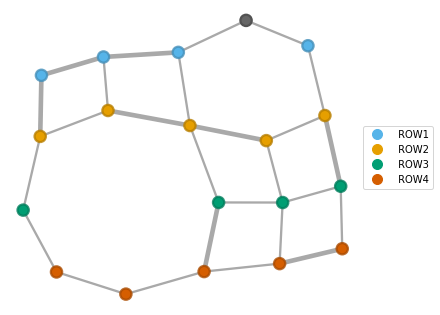

In [146]:
row_2 = (nflat.select_any([nflat.row_tag(2), nflat.row_tag(3)]) & row_envs['below',3] & row_envs['above',2])

row_2.graph(color=['ROW1', 'ROW2', 'ROW3', 'ROW4'], show_tags=False)

In [162]:
row_envs['below', 3].tensors

(Tensor(shape=(5, 5), inds=('_a28ab0AARZP', '_a28ab0AARaj'), tags=oset(['VERT', 'Q6', 'S4,0', 'ROW4', 'COL0'])),
 Tensor(shape=(5, 5), inds=('_a28ab0AARZP', '_a28ab0AARap'), tags=oset(['ROW4', 'COL1', 'S3,1'])),
 Tensor(shape=(25, 5, 5), inds=('_a28ab0AARZM', '_a28ab0AARaF', '_a28ab0AARap'), tags=oset(['VERT', 'Q7', 'S4,2', 'ROW4', 'COL2'])),
 Tensor(shape=(25, 5, 5), inds=('_a28ab0AARZQ', '_a28ab0AARZX', '_a28ab0AARaF'), tags=oset(['AUX', 'S4,3', 'ROW4', 'COL3'])),
 Tensor(shape=(25, 5), inds=('_a28ab0AARZQ', '_a28ab0AARaB'), tags=oset(['VERT', 'Q8', 'S4,4', 'ROW4', 'COL4'])))

[[None, None, None, None, None],
 [oset(['VERT', 'Q0', 'ROW0', 'COL0', 'AUX', 'S1,0', 'ROW1']),
  oset(['FACE', 'Q9', 'S1,1', 'ROW1', 'COL1', 'AUX', 'ROW0']),
  oset(['VERT', 'Q1', 'ROW0', 'COL2', 'AUX', 'S1,2', 'ROW1']),
  oset(['ROW0', 'COL3', 'S1,3']),
  oset(['VERT', 'Q2', 'ROW0', 'COL4', 'S1,4', 'ROW1'])],
 [oset(['S2,0', 'ROW2', 'COL0']),
  oset(['S2,1', 'ROW2', 'COL1']),
  oset(['S2,2', 'ROW2', 'COL2']),
  oset(['S2,3', 'ROW2', 'COL3']),
  oset(['S2,4', 'ROW2', 'COL4'])],
 [oset(['S3,0', 'ROW3', 'COL0']),
  None,
  oset(['S3,2', 'ROW3', 'COL2']),
  oset(['S3,3', 'ROW3', 'COL3']),
  oset(['S3,4', 'ROW3', 'COL4'])],
 [oset(['VERT', 'Q6', 'S4,0', 'ROW4', 'COL0']),
  oset(['ROW4', 'COL1', 'S3,1']),
  oset(['VERT', 'Q7', 'S4,2', 'ROW4', 'COL2']),
  oset(['AUX', 'S4,3', 'ROW4', 'COL3']),
  oset(['VERT', 'Q8', 'S4,4', 'ROW4', 'COL4'])]]

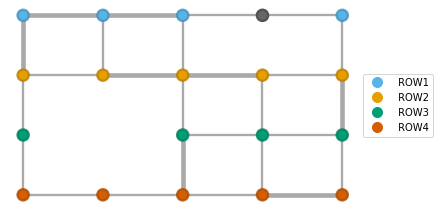

In [156]:
row23 = nflat.row_environment_sandwich(x0=2, x_bsz=2, row_envs=row_envs)
row23.graph(color=['ROW1', 'ROW2', 'ROW3', 'ROW4'])
row23.supergrid()